--------------- Epoch 1 ---------------


100%|██████████| 468/468 [00:38<00:00, 12.24it/s]


4/4 [==============================] - 0s 6ms/step


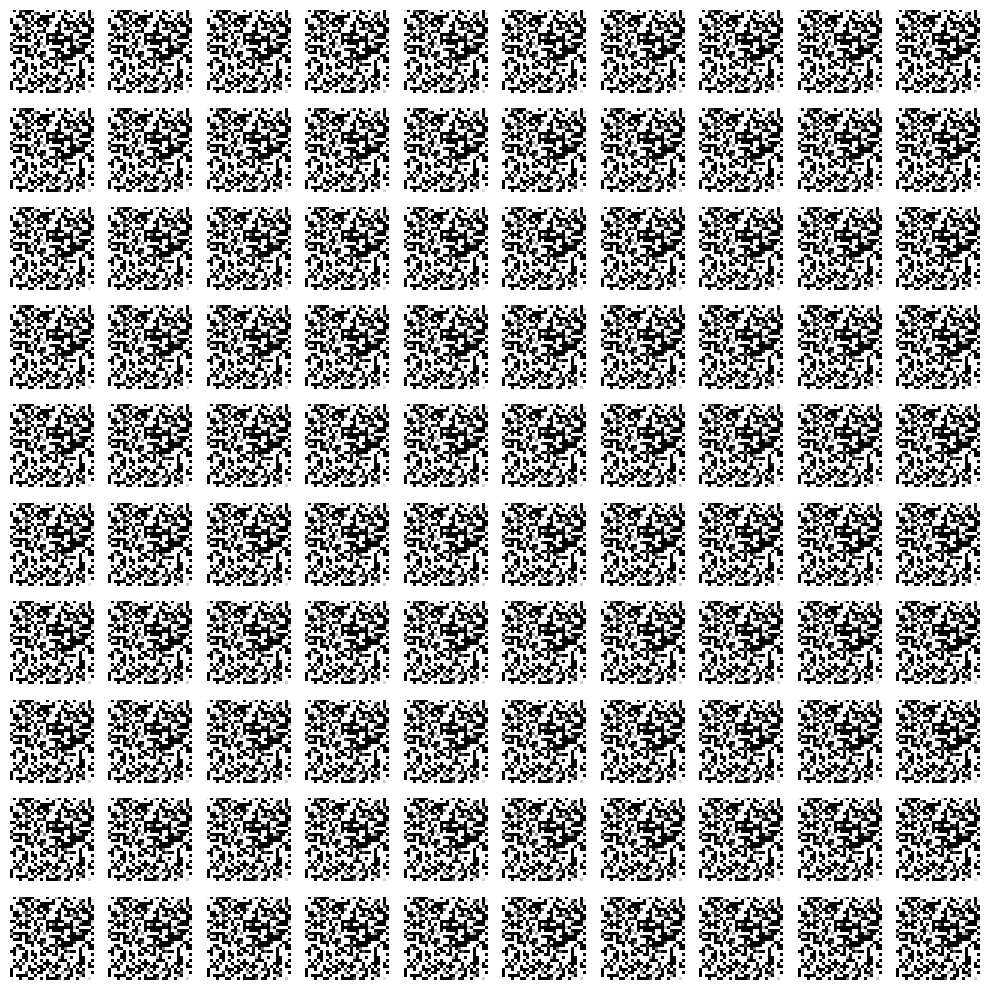

--------------- Epoch 2 ---------------


 43%|████▎     | 203/468 [00:16<00:21, 12.42it/s]


KeyboardInterrupt: 

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow.keras.datasets import mnist

# Let Keras know that we are using tensorflow as our backend engine
os.environ["KERAS_BACKEND"] = "tensorflow"
# To make sure that we can reproduce the experiment and get the same results
np.random.seed(10)
# The dimension of our random noise vector.
random_dim = 100

def load_mnist_data():
    # load the data
    (x_train, _), (_, _) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1] 
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return x_train

def get_optimizer():
    return LegacyAdam(lr=0.0002, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the 
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
    plt.show()
    

def train(epochs=1, batch_size=128):
    # Get the training data
    x_train = load_mnist_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] // batch_size

    # Build our GAN network
    optimizer = Adam(lr=0.0002, beta_1=0.5)
    generator = get_generator(optimizer)
    discriminator = get_discriminator(optimizer)
    gan = get_gan_network(discriminator, random_dim, generator, optimizer)

    for e in range(1, epochs+1):
        print('-' * 15, 'Epoch %d' % e, '-' * 15)
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            with tf.GradientTape(persistent=True) as tape:
                generated_images = generator(noise)
                X = tf.concat([image_batch, generated_images], axis=0)
                y_dis = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

                dis_output = discriminator(X)
                loss_discriminator = tf.keras.losses.binary_crossentropy(y_dis, dis_output)
                loss_discriminator = tf.reduce_mean(loss_discriminator)

                y_gen = tf.ones((batch_size, 1))
                gan_output = gan(noise)
                loss_generator = tf.keras.losses.binary_crossentropy(y_gen, gan_output)
                loss_generator = tf.reduce_mean(loss_generator)

            grads_discriminator = tape.gradient(loss_discriminator, discriminator.trainable_variables)
            optimizer.apply_gradients(zip(grads_discriminator, discriminator.trainable_variables))

            grads_generator = tape.gradient(loss_generator, generator.trainable_variables)
            optimizer.apply_gradients(zip(grads_generator, generator.trainable_variables))

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

if __name__ == '__main__':
    train(100, 128)
